In [1]:

from buffers import MultiEnvReplayBuffer
from bnn import BNN
from lion_opt import Lion
from planner_module_v4 import Planner
from metaworld.envs import (ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE)

from collections import defaultdict
from IPython.display import clear_output

import numpy as np
import torchbnn as bnn
import torch.nn as nn
import matplotlib.pyplot as plt
import torch
import pickle
import json
import random
import os
import time
import tqdm


In [2]:
# for maximum compatibility with numpy array
torch.set_default_dtype(torch.float64)

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)


In [3]:

def save_json_update(json_obj):
    with open('config_parameters.json', 'w') as f:
        json.dump(json_obj, f)


def json_load():
    with open('config_parameters.json', 'r') as f:
        config_file = json.load(f)
    return config_file


def save_torch_models(models: dict, path,):
    for k, model in models.items():
        name = os.path.join(path, f'model_env{k}.pth')
        torch.save(model.state_dict(), name)
        
        
def save_binary_obj(obj, path, name_template: str):
    name = os.path.join(path, name_template+'.pkl')
    with open(name, 'wb') as f:
        pickle.dump(obj, f)



def load_binary_file(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj



In [4]:

def update_with_elbo(net, buffer, optimizer, task_id):
    """
   training loop
    """
    states, actions, rewards, next_states, dones = buffer.sample_all_envs(batch_size=BATCH_SIZE) if (
                task_id == -1) else buffer.sample_env(task_id, batch_size=BATCH_SIZE)

    optimizer.zero_grad()
    x = torch.Tensor(np.concatenate((states, actions), axis=-1)).to(DEVICE)
    y_true = torch.Tensor(np.concatenate((next_states, rewards), axis=-1)).to(DEVICE)
    y_pred = net(x)

    mse = mse_loss(y_pred, y_true)
    kl = kl_loss(net)
    loss = mse + KL_WEIGHT * kl
    loss.backward()
    optimizer.step()
    return mse.item(), kl.item(), loss.item()


def test_with_elbo(net, buffer, task_id):
    """
   test loop
    """
    states, actions, rewards, next_states, dones = buffer.sample_all_envs(batch_size=BATCH_SIZE) if (
                task_id == -1) else buffer.sample_env(task_id, batch_size=BATCH_SIZE)

    with torch.no_grad():
        
        x = torch.Tensor(np.concatenate((states, actions), axis=-1)).to(DEVICE)
        y_true = torch.Tensor(np.concatenate((next_states, rewards), axis=-1)).to(DEVICE)
        y_pred = net(x)

        mse = mse_loss(y_pred, y_true)
        kl = kl_loss(net)
        loss = mse + KL_WEIGHT * kl
    
    return mse.item(), kl.item(), loss.item()



In [5]:
config = json_load()

# nested struct
buff_config = config['buffer']
planner_config = config['planner']
const_config = config['const']
train_config = config['train']
'''
i load only the var that i need inside the
traininig loop, not in the initialization of the
object. If each time i should look inside the dict,
i'll consume operation
'''
DEVICE = const_config['DEVICE']
BATCH_SIZE = train_config['BATCH_SIZE']
KL_WEIGHT = train_config['KL_WEIGHT']
EPISODE_FOR_TASK = train_config['EPISODE_FOR_TASK']

# Envs creation 


In [6]:
envs_name = list(ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE.keys())
envs = {}
for name in random.sample(envs_name,  const_config['NUMB_ENVS']):
#for name in envs_name:
    if not buff_config["correspondence_id2env"].get(name, 0):
        buff_config["correspondence_id2env"][name] = buff_config["correspondence_id2env"]["first_idx_free"]
        buff_config["correspondence_id2env"]["first_idx_free"] += 1
    envs[buff_config["correspondence_id2env"][name]] = ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE[name]()

config['buffer'] = buff_config
save_json_update(config)

/home/dema/PycharmProjects/lifelong_rl/venv/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float64
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/dema/PycharmProjects/lifelong_rl/venv/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


# MultiBuffer init, load data or fill buffers

create a multi-env buffer, using the mapping from `config.dict[name : index]`
we load all old transitions OR we do random step for collect new transitions (new env)
            
small note: the update for the world should be done with all the buffer, so we should load all

In [7]:
multibuffer = MultiEnvReplayBuffer(
    buffer_size_per_env=buff_config['max_size_for_env']
)

In [8]:
# ----- load automatically all the buffer ------
if buff_config['preload']:
    multibuffer.read_buffers(buff_config['IO_option']['path'],
                             buff_config['IO_option']['from_scratch']
                            )

old buffer to load: name: ['buffer_env48.pkl', 'buffer_env22.pkl', 'buffer_env41.pkl', 'buffer_env43.pkl', 'buffer_env29.pkl', 'buffer_env09.pkl', 'buffer_env34.pkl', 'buffer_env40.pkl', 'buffer_env26.pkl', 'buffer_env01.pkl', 'buffer_env10.pkl', 'buffer_env13.pkl', 'buffer_env42.pkl', 'buffer_env49.pkl', 'buffer_env19.pkl', 'buffer_env45.pkl', 'buffer_env46.pkl', 'buffer_env35.pkl', 'buffer_env32.pkl', 'buffer_env50.pkl', 'buffer_env04.pkl', 'buffer_env15.pkl', 'buffer_env28.pkl', 'buffer_env20.pkl', 'buffer_env06.pkl', 'buffer_env18.pkl', 'buffer_env07.pkl', 'buffer_env33.pkl', 'buffer_env12.pkl', 'buffer_env16.pkl', 'buffer_env11.pkl', 'buffer_env23.pkl', 'buffer_env36.pkl', 'buffer_env05.pkl', 'buffer_env08.pkl', 'buffer_env30.pkl', 'buffer_env37.pkl', 'buffer_env14.pkl', 'buffer_env38.pkl', 'buffer_env24.pkl', 'buffer_env39.pkl', 'buffer_env17.pkl', 'buffer_env21.pkl', 'buffer_env44.pkl', 'buffer_env25.pkl', 'buffer_env31.pkl', 'buffer_env27.pkl', 'buffer_env03.pkl', 'buffer_env02

In [9]:
# ---- random action for empty buffer ---------
for k in envs.keys():
    if multibuffer.elem_for_buffer[k] == 0:
        # if not any sample for that exp: do random move
        print(f'adding random step for model {k}')
        for _ in range(20):
            s = envs[k].reset()
            for _ in range(50):
                act = envs[k].action_space.sample()
                new_s, reward, done, info = envs[k].step(act)
                multibuffer.add(s, act, reward, new_s, done, env_id=k)
                s = new_s

In [10]:
# --------------- save new buffer ---------------
multibuffer.write_buffer(buff_config['IO_option']['path'])

### test buffer:
Create a second buffer with random sample, this buffer is used only for evaluate the performance of the world model in the pre training phase

In [11]:
test_multibuffer = MultiEnvReplayBuffer(
        buffer_size_per_env=buff_config['max_size_for_env']
)

for k in envs.keys():
    s = envs[k].reset()
    num_sampled_transition = 200
    for _ in range(num_sampled_transition//planner_config['plan_horizon']):
        s = envs[k].reset()
        for _ in range(planner_config['plan_horizon']):
            act = envs[k].action_space.sample()
            new_s, reward, done, info = envs[k].step(act)
            test_multibuffer.add(s, act, reward, new_s, done, env_id=k)
            s = new_s
        
test_multibuffer.elem_for_buffer

defaultdict(<function buffers.MultiEnvReplayBuffer.__init__.<locals>.<lambda>()>,
            {5: 180, 29: 180, 40: 180, 39: 180, 13: 180})

# MODEL INIT

### World model:


In [19]:

world_model = BNN(action_dim=const_config['ACTION_SHAPE'],
                  obs_dim=const_config['OBS_SHAPE'],
                  reward_dim=const_config['REWARD_SHAPE'],
                  ).to(DEVICE)

model_name = os.path.join(
    train_config['path_world_model'],
    train_config['selected_world_model']
)

outer_opt_for_pretrain = Lion(world_model.parameters(), lr=train_config['LR_OUTER_INIT_TRAIN'])
outer_opt = Lion(world_model.parameters(), lr=train_config['LR_OUTER'])



if os.path.isfile(model_name) and train_config['LOAD_WORLD_MODEL']:
    world_model.load_state_dict(torch.load(model_name))
    outer_opt = load_binary_file(os.path.join(train_config['path_optimizer_world'], train_config['opt_world_model']))
    print(f"load world model from {train_config['selected_world_model']}")


load world model from model_envWorld_checkpoint35000.pth


### Task specific models:

In [20]:
task_specific_models = {}
planners = {}
optimizers = {}

for idx in envs.keys():
    planner_name = os.path.join(planner_config['path_planner'], f'planner_env{idx}.pkl')
    optimizer_name = os.path.join(train_config['path_optimizer'], f'optimizer_env{idx}.pkl')

    #MODELS
    if train_config['LOAD_TASK_MODEL'] and (os.path.isfile(planner_name) and os.path.isfile(optimizer_name)):
        planners[idx] = load_binary_file(planner_name)   # ps: the net will be load in cuda by default
        optimizers[idx] = load_binary_file(optimizer_name)
        print(f'model {idx} loaded')
    else:
        task_specific_models[idx] = BNN(const_config['ACTION_SHAPE'],
                                        obs_dim=const_config['OBS_SHAPE'],
                                        reward_dim=const_config['REWARD_SHAPE'],
                                        ).to(DEVICE)
        planners[idx] = Planner(
            stochastic_dyna=task_specific_models[idx],
            plan_horizon=planner_config['plan_horizon'],
            num_particles=planner_config['num_particles'],
            num_sequence_action=planner_config['cem']['num_sequence_action'],
            percent_elite=planner_config['cem']['percent_elit'],
            env_action_space_shape=const_config['ACTION_SHAPE'],
            env_obs_space_shape=const_config['OBS_SHAPE'],
        )
        optimizers[idx] = Lion(task_specific_models[idx].parameters(),
                               lr=train_config['LR_INNER'])


### Loss

In [21]:
mse_loss = nn.MSELoss().to(DEVICE)
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False).to(DEVICE)

# PRE-TRAIN World Model

In [22]:
# stock for loss
if not train_config['LOAD_WORLD_MODEL']:   
    losses_mse_train = []
    losses_kl_train = []
    total_loss_train = []

    losses_mse_test = []
    losses_kl_test = []
    total_loss_test = []


    losses_kl_partial = []
    losses_mse_partial = []
    total_loss_partial = []

In [17]:
if not train_config['LOAD_WORLD_MODEL']:   


    epochs =  train_config['EPOCH_WORLD_MODEL_PRETRAIN']
    for ep in tqdm.tqdm(range(epochs)):

        loss = update_with_elbo(world_model, multibuffer, optimizer=outer_opt_for_pretrain, task_id=-1)
        losses_mse_partial.append(loss[0])
        losses_kl_partial.append(loss[1])
        total_loss_partial.append(loss[2])

        if ep%10 == 0 :
            losses_mse_train.append((sum(losses_mse_partial)/len(losses_mse_partial)))
            losses_kl_train.append((sum(losses_kl_partial)/len(losses_kl_partial)))
            total_loss_train.append((sum(total_loss_partial)/len(total_loss_partial)))


            losses_kl_partial = []
            losses_mse_partial = []
            total_loss_partial = []

            test_loss = test_with_elbo(world_model, test_multibuffer, task_id=-1)

            losses_mse_test.append(test_loss[0])
            losses_kl_test.append(test_loss[1])
            total_loss_test.append(test_loss[2])
            
    torch.save(world_model.state_dict(), os.path.join(train_config['path_world_model'], f'World_checkpoint{epochs}.pth'))
    save_binary_obj(outer_opt, train_config['path_optimizer_world'], name_template=f'optimizer_world_{epochs}')


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35000/35000 [02:32<00:00, 228.84it/s]


In [36]:
torch.save(world_model.state_dict(), os.path.join(train_config['path_world_model'], f'World_checkpoint{epochs}.pth'))


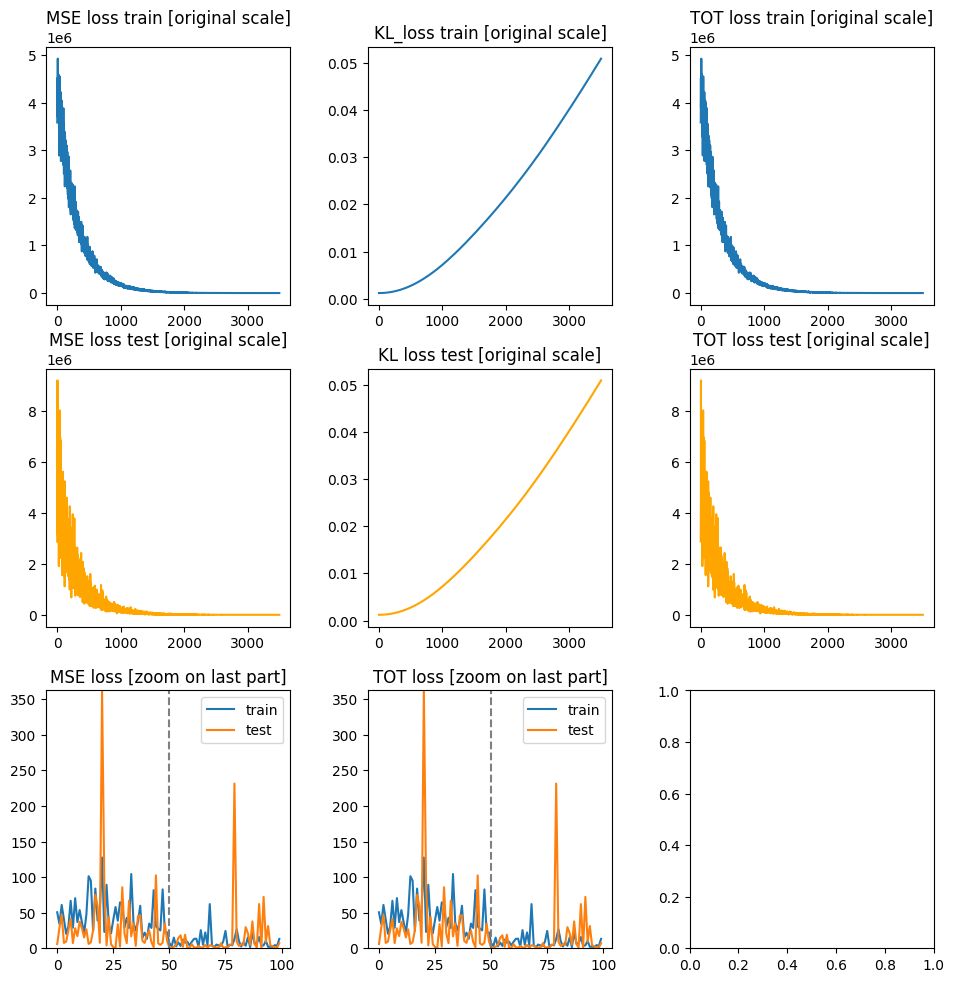

In [18]:
if not train_config['LOAD_WORLD_MODEL']:   

    fig, axes = plt.subplots(3,3, figsize=(10, 10))

    fig.tight_layout(pad=2.5)

    axes[0][0].plot(losses_mse_train, label='train')
    axes[0][0].set_title('MSE loss train [original scale]')

    axes[0][1].plot(losses_kl_train, label='train')
    axes[0][1].set_title('KL_loss train [original scale]')

    axes[0][2].plot(total_loss_train, label='train')
    axes[0][2].set_title('TOT loss train [original scale]')


    axes[1][0].plot(losses_mse_test, color='orange')
    axes[1][0].set_title('MSE loss test [original scale]')

    axes[1][1].plot(losses_kl_test, color='orange')
    axes[1][1].set_title('KL loss test [original scale]')

    axes[1][2].plot(total_loss_test, color='orange')
    axes[1][2].set_title('TOT loss test [original scale]')



    concat_losses_mse_train = losses_mse_train[-400:-350] + losses_mse_train[-50:]
    concat_losses_mse_test = losses_mse_test[-400:-350] + losses_mse_test[-50:]
    axes[2][0].set_ylim(0, max(concat_losses_mse_test))
    axes[2][0].plot(concat_losses_mse_train, label='train') 
    axes[2][0].plot(concat_losses_mse_test, label='test') 
    axes[2][0].vlines(x=50, ymin=0, ymax=max(concat_losses_mse_test+concat_losses_mse_train), color='gray', linestyles='dashed')
    axes[2][0].set_title('MSE loss [zoom on last part]')
    axes[2][0].legend()

    concat_tot_loss_train = total_loss_train[-400:-350] + total_loss_train[-50:]
    concat_tot_loss_test = total_loss_test[-400:-350] + total_loss_test[-50:]
    axes[2][1].set_ylim(0, max(concat_tot_loss_test))
    axes[2][1].plot(concat_tot_loss_train, label='train')
    axes[2][1].plot(concat_tot_loss_test, label='test')
    axes[2][1].vlines(x=50, ymin=0, ymax=max(concat_tot_loss_test + concat_tot_loss_train), color='gray', linestyles='dashed')
    axes[2][1].set_title('TOT loss [zoom on last part]')
    axes[2][1].legend()

    plt.show()

In [35]:
sum(total_loss_train[-10:])/10, sum(total_loss_test[-10:])/10

(6.098343786197233, 19.145867422984406)

# MAIN : run loop over subtask


In [23]:
reward_dict = defaultdict(list)
for k in envs.keys():
    
    planners[k].dynamic.copy_params_from_model(world_model.state_dict())
    for ep in range(EPISODE_FOR_TASK):
    
        clear_output(wait=True)
        actual_state = envs[k].reset()
        reward_for_ep = []
        
        # for t in range(200):     # should replan 
        for t in range(planner_config['plan_horizon']):  # default value plan horizon: 20
            
            best_action = planners[k].plan_step(actual_state)
            new_state, reward, done, info = envs[k].step(best_action)
            multibuffer.add(actual_state, best_action, reward, new_state, done, env_id=k)
            
            actual_state = new_state
            reward_for_ep.append(reward)
            
            loss = update_with_elbo(planners[k].dynamic, multibuffer, optimizer=optimizers[k], task_id=k)
            
            print(f'env_{k}| ep: {ep}| step:{t}| [mse, kl, tot_loss] ({loss[0]:.4f}, {loss[1]:.4f} {loss[2]:.4f}), | reward {reward:.5f} ')
            if done: break

        avg_reward_for_ep = np.mean(reward_for_ep)
        reward_dict[k].append(avg_reward_for_ep)
        print(f'#---------- avg rew for ep {avg_reward_for_ep}')
        loss_world = update_with_elbo(world_model, multibuffer, optimizer=outer_opt, task_id=-1)
        print(f'#----------  loss for world_model {loss_world[2]}')
        
        multibuffer.write_buffer(buff_config['IO_option']['path'])
        
        save_binary_obj(planners[k], planner_config['path_planner'], name_template=f'planner_env{k}')
        save_binary_obj(optimizers[k], train_config['path_optimizer'], name_template=f'optimizer_env{k}')
        save_binary_obj(outer_opt, train_config['path_optimizer_world'], name_template='optimizer_world')
        
        torch.save(world_model.state_dict(), os.path.join(train_config['path_world_model'], 'world_extra.pth'))


KeyboardInterrupt: 

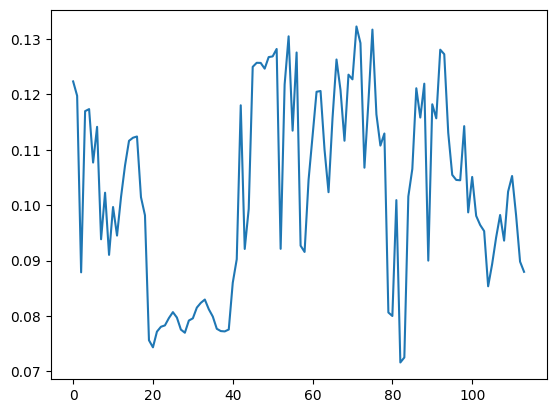

In [24]:
plt.plot(reward_dict[5])